# Train a reinforcement model that follows the line

First we import the necessary simulator libraries
- CarModel: a simulated car
- CanvasModel: a simulated training ground where the car can follow a line
- SimulatorControl: an environment where we can simulate actions like driving forward or turning left and right and read out new sensor values

In [1]:
import logging
import Car
import Canvas
import RobotCarSimulator

In [2]:
car = Car.CarModel()
# the seed controls the curve/line that we are following
canvas = Canvas.CanvasModel(seed=11)
# we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=False)

Model hyperparameters

In [3]:
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
TAU = 1e-2                # soft update
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
MEMORY_SIZE = 100_000     # size of memory buffer
MINIBATCH_SIZE = 64   # mini-batch size
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy

## Action space

- 0 - driveForward(100,150)
- 1 - turnLeft(100,50)
- 2 - turnRight(100,50)

In [4]:
def driveForward():
    global sim
    sim.driveForward(100,150)

def turnLeft():
    global sim
    sim.turnLeft(100,50)
    
def turnRight():
    global sim
    sim.turnRight(100,50)
    
actions = (driveForward, turnLeft, turnRight)

num_actions = len(actions)

#to invoke action 0:
#actions[0]()

## Observation space

the observation space is only the sensor values of the 3 infrared sensors and the time exceeded (duration)

In [5]:
import numpy as np

def getReward():
    global sim
    return sim.getReward()

def getSensors():
    global sim
    return sim.getLineTrackingSensorValues()

def getDuration():
    global sim
    return sim.getDuration()

def isDone():
    global sim
    return sim.isTerminated()


# run one step and return next state (sensors), reward, done and time exceeded
def step(action):
    action()
    return (np.array(getSensors()), isDone(), getReward(), getDuration())
    
next_state, done, reward, duration = step(actions[0])     
    
state_size = 3 # we have three sensors

print(next_state, done, reward, duration) 

[ 30.         146.91333487 900.        ] False 25.31632308051881 0.25


# Deep Q-learning (reinforcement learning)

as learned in the coursera course we will use two models, the Q and target Q' networks (Deep Q Network) DQN.

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from collections import deque, namedtuple # for experience replay
import numpy as np
import random

In [7]:
# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ### 
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ###
    ])


optimizer = Adam(learning_rate=ALPHA)           


2022-08-22 21:24:26.758683: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 21:24:26.758946: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Experience replay 

The coursera course recommends to use experience replay to avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.

In [8]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [9]:
# calculate_loss

def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###
    
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ### 
    
    return loss

In [10]:
def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [11]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

In [12]:
def get_action(q_values, epsilon=0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(num_actions))

In [13]:
def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False

In [14]:
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

In [15]:
def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)

In [16]:
import time
import pprint
import sys
start = time.time()

num_episodes = 2000
max_num_timesteps = 500

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())
# learn with 9 different curves to generalize the model and not optimize for a single curve
seeds = (2,5,9,11,13,15,17,19,21)

duration = 0.0

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    car = Car.CarModel()
    # the seed controls the curve/line that we are following
    seed = seeds[i%len(seeds)]
    canvas = Canvas.CanvasModel(seed=seed)
    # we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
    sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=False)
    state = np.array(getSensors())
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, done, reward, duration = step(actions[action])   
       
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            #print("\nUpdating model after ",t," steps")
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            print("\nBreaking episode ",i," with seed ", seed, " after ",t," steps with reward ",total_points)
            break
        if (t==(max_num_timesteps-1)):
            print("\nAborting episode ",i," with seed ", seed, " after ",t," steps with reward ",total_points)
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
        with open('train_episode_{}_seed_{}.txt'.format(i,seed), 'w') as f:
            f.write("actions:\n")
            f.write(pprint.pformat(sim._actionLog))
            f.write("\n\npositions:\n")
            f.write(pprint.pformat(sim._carPositions))
            f.write("\n\norientations:\n")
            f.write(pprint.pformat(sim._carOrientations))

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 25000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('curve_tracking_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
q_network.save('curve_tracking_model.h5')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Breaking episode  0  with seed  2  after  99  steps with reward  -14326.0
Episode 1 | Total point average of the last 100 episodes: -14326.00
Breaking episode  1  with seed  5  after  121  steps with reward  -29871.37312436144
Episode 2 | Total point average of the last 100 episodes: -22098.69
Breaking episode  2  with seed  9  after  51  steps with reward  -23653.91593986831
Episode 3 | Total point average of the last 100 episodes: -22617.10
Breaking episode  3  with seed  11  after  127  steps with r

Episode 50 | Total point average of the last 100 episodes: -24308.15
Breaking episode  50  with seed  15  after  175  steps with reward  -19119.35166845986
Episode 51 | Total point average of the last 100 episodes: -24206.41
Breaking episode  51  with seed  17  after  210  steps with reward  -42102.78416676014
Episode 52 | Total point average of the last 100 episodes: -24550.57
Breaking episode  52  with seed  19  after  52  steps with reward  -20207.998255560367
Episode 53 | Total point average of the last 100 episodes: -24468.63
Breaking episode  53  with seed  21  after  146  steps with reward  -16795.781065621188
Episode 54 | Total point average of the last 100 episodes: -24326.54
Breaking episode  54  with seed  2  after  260  steps with reward  -61713.645018413205
Episode 55 | Total point average of the last 100 episodes: -25006.31
Breaking episode  55  with seed  5  after  163  steps with reward  -37095.92741839896
Episode 56 | Total point average of the last 100 episodes: -2522

Episode 103 | Total point average of the last 100 episodes: -18495.21
Breaking episode  103  with seed  13  after  147  steps with reward  -3362.813817635948
Episode 104 | Total point average of the last 100 episodes: -18119.83
Breaking episode  104  with seed  15  after  151  steps with reward  -25381.67711619669
Episode 105 | Total point average of the last 100 episodes: -18093.21
Aborting episode  105  with seed  17  after  499  steps with reward  -6691.146363483793
Episode 106 | Total point average of the last 100 episodes: -17788.62
Breaking episode  106  with seed  19  after  183  steps with reward  -3340.420477151829
Episode 107 | Total point average of the last 100 episodes: -17803.39
Breaking episode  107  with seed  21  after  130  steps with reward  -23088.131656795813
Episode 108 | Total point average of the last 100 episodes: -17693.32
Aborting episode  108  with seed  2  after  499  steps with reward  -12202.689884916286
Episode 109 | Total point average of the last 100 e

Episode 155 | Total point average of the last 100 episodes: -7065.10
Breaking episode  155  with seed  9  after  45  steps with reward  -1371.9220001531914
Episode 156 | Total point average of the last 100 episodes: -6707.86
Aborting episode  156  with seed  11  after  499  steps with reward  5528.53501146463
Episode 157 | Total point average of the last 100 episodes: -6627.31
Breaking episode  157  with seed  13  after  176  steps with reward  -3467.2096846631503
Episode 158 | Total point average of the last 100 episodes: -6434.38
Breaking episode  158  with seed  15  after  171  steps with reward  32198.02887486439
Episode 159 | Total point average of the last 100 episodes: -6009.87
Aborting episode  159  with seed  17  after  499  steps with reward  3590.6759045893978
Episode 160 | Total point average of the last 100 episodes: -5708.09
Breaking episode  160  with seed  19  after  488  steps with reward  22755.72167678992
Episode 161 | Total point average of the last 100 episodes: -5

Episode 208 | Total point average of the last 100 episodes: 812.33
Aborting episode  208  with seed  5  after  499  steps with reward  1740.401075834685
Episode 209 | Total point average of the last 100 episodes: 951.76
Breaking episode  209  with seed  9  after  84  steps with reward  1036.9259884128383
Episode 210 | Total point average of the last 100 episodes: 985.35
Breaking episode  210  with seed  11  after  101  steps with reward  -7820.632296183685
Episode 211 | Total point average of the last 100 episodes: 932.23
Breaking episode  211  with seed  13  after  336  steps with reward  29141.521033721627
Episode 212 | Total point average of the last 100 episodes: 1258.48
Breaking episode  212  with seed  15  after  390  steps with reward  35074.94629664146
Episode 213 | Total point average of the last 100 episodes: 1599.48
Aborting episode  213  with seed  17  after  499  steps with reward  2012.381162543273
Episode 214 | Total point average of the last 100 episodes: 1868.14
Breaki

Episode 261 | Total point average of the last 100 episodes: 2652.59
Aborting episode  261  with seed  2  after  499  steps with reward  11382.5805255532
Episode 262 | Total point average of the last 100 episodes: 2745.60
Aborting episode  262  with seed  5  after  499  steps with reward  -14898.176203777533
Episode 263 | Total point average of the last 100 episodes: 2653.80
Breaking episode  263  with seed  9  after  47  steps with reward  510.67624873325735
Episode 264 | Total point average of the last 100 episodes: 2648.85
Aborting episode  264  with seed  11  after  499  steps with reward  2027.3022258156443
Episode 265 | Total point average of the last 100 episodes: 2663.70
Breaking episode  265  with seed  13  after  58  steps with reward  -9677.565026390093
Episode 266 | Total point average of the last 100 episodes: 2768.83
Breaking episode  266  with seed  15  after  246  steps with reward  30783.47249206899
Episode 267 | Total point average of the last 100 episodes: 2777.86
Abo

Episode 314 | Total point average of the last 100 episodes: 2213.89
Breaking episode  314  with seed  21  after  432  steps with reward  4326.065122365624
Episode 315 | Total point average of the last 100 episodes: 2228.75
Aborting episode  315  with seed  2  after  499  steps with reward  18655.481285654936
Episode 316 | Total point average of the last 100 episodes: 2392.02
Aborting episode  316  with seed  5  after  499  steps with reward  9284.684998019507
Episode 317 | Total point average of the last 100 episodes: 2385.28
Breaking episode  317  with seed  9  after  31  steps with reward  -14672.0
Episode 318 | Total point average of the last 100 episodes: 2190.90
Breaking episode  318  with seed  11  after  455  steps with reward  35905.76675025998
Episode 319 | Total point average of the last 100 episodes: 2714.54
Aborting episode  319  with seed  13  after  499  steps with reward  -5218.8916735414
Episode 320 | Total point average of the last 100 episodes: 2496.35
Breaking episod

Episode 367 | Total point average of the last 100 episodes: 6580.00
Breaking episode  367  with seed  19  after  470  steps with reward  -4222.217489050837
Episode 368 | Total point average of the last 100 episodes: 6535.67
Breaking episode  368  with seed  21  after  270  steps with reward  2210.4927853511117
Episode 369 | Total point average of the last 100 episodes: 6748.23
Breaking episode  369  with seed  2  after  328  steps with reward  31587.24603114365
Episode 370 | Total point average of the last 100 episodes: 7185.22
Breaking episode  370  with seed  5  after  304  steps with reward  37658.29967636829
Episode 371 | Total point average of the last 100 episodes: 7448.00
Breaking episode  371  with seed  9  after  76  steps with reward  1044.8601081500508
Episode 372 | Total point average of the last 100 episodes: 7339.62
Aborting episode  372  with seed  11  after  499  steps with reward  20664.021706450167
Episode 373 | Total point average of the last 100 episodes: 7692.72
Br

Episode 420 | Total point average of the last 100 episodes: 10123.87
Aborting episode  420  with seed  17  after  499  steps with reward  6915.008291984629
Episode 421 | Total point average of the last 100 episodes: 9876.57
Aborting episode  421  with seed  19  after  499  steps with reward  11898.213462727548
Episode 422 | Total point average of the last 100 episodes: 9986.68
Breaking episode  422  with seed  21  after  365  steps with reward  32107.21744970362
Episode 423 | Total point average of the last 100 episodes: 10145.77
Aborting episode  423  with seed  2  after  499  steps with reward  3343.996203886154
Episode 424 | Total point average of the last 100 episodes: 10218.86
Aborting episode  424  with seed  5  after  499  steps with reward  5508.7457395114525
Episode 425 | Total point average of the last 100 episodes: 10124.61
Breaking episode  425  with seed  9  after  82  steps with reward  288.0
Episode 426 | Total point average of the last 100 episodes: 10016.77
Aborting ep

Episode 473 | Total point average of the last 100 episodes: 8467.07
Aborting episode  473  with seed  15  after  499  steps with reward  6774.05291240583
Episode 474 | Total point average of the last 100 episodes: 8216.75
Aborting episode  474  with seed  17  after  499  steps with reward  6418.763916684346
Episode 475 | Total point average of the last 100 episodes: 8193.28
Aborting episode  475  with seed  19  after  499  steps with reward  5913.567833220583
Episode 476 | Total point average of the last 100 episodes: 8184.64
Aborting episode  476  with seed  21  after  499  steps with reward  7944.094011690076
Episode 477 | Total point average of the last 100 episodes: 8173.81
Breaking episode  477  with seed  2  after  195  steps with reward  30770.30753315585
Episode 478 | Total point average of the last 100 episodes: 8152.22
Aborting episode  478  with seed  5  after  499  steps with reward  14853.256847991883
Episode 479 | Total point average of the last 100 episodes: 8235.54
Brea

Episode 526 | Total point average of the last 100 episodes: 6303.34
Aborting episode  526  with seed  13  after  499  steps with reward  -2455.624068942484
Episode 527 | Total point average of the last 100 episodes: 6168.14
Breaking episode  527  with seed  15  after  3  steps with reward  -14970.0
Episode 528 | Total point average of the last 100 episodes: 5884.05
Aborting episode  528  with seed  17  after  499  steps with reward  3381.8668558368963
Episode 529 | Total point average of the last 100 episodes: 5858.82
Breaking episode  529  with seed  19  after  39  steps with reward  -14259.903890653071
Episode 530 | Total point average of the last 100 episodes: 5643.97
Aborting episode  530  with seed  21  after  499  steps with reward  9205.086209761135
Episode 531 | Total point average of the last 100 episodes: 5610.85
Breaking episode  531  with seed  2  after  161  steps with reward  1611.087153811508
Episode 532 | Total point average of the last 100 episodes: 5465.32
Breaking ep

Episode 580 | Total point average of the last 100 episodes: 3241.04
Breaking episode  580  with seed  13  after  130  steps with reward  -12452.175222005622
Episode 581 | Total point average of the last 100 episodes: 3056.64
Breaking episode  581  with seed  15  after  68  steps with reward  -34480.0
Episode 582 | Total point average of the last 100 episodes: 2688.06
Aborting episode  582  with seed  17  after  499  steps with reward  6814.874431312155
Episode 583 | Total point average of the last 100 episodes: 2666.95
Breaking episode  583  with seed  19  after  58  steps with reward  -25222.837106747662
Episode 584 | Total point average of the last 100 episodes: 2379.53
Aborting episode  584  with seed  21  after  499  steps with reward  10023.980657202534
Episode 585 | Total point average of the last 100 episodes: 2406.59
Breaking episode  585  with seed  2  after  92  steps with reward  18634.89786784182
Episode 586 | Total point average of the last 100 episodes: 2495.00
Breaking e

Episode 633 | Total point average of the last 100 episodes: 2811.39
Aborting episode  633  with seed  11  after  499  steps with reward  4659.753332338779
Episode 634 | Total point average of the last 100 episodes: 3004.85
Breaking episode  634  with seed  13  after  394  steps with reward  29928.66807744391
Episode 635 | Total point average of the last 100 episodes: 3255.04
Aborting episode  635  with seed  15  after  499  steps with reward  16971.375705501934
Episode 636 | Total point average of the last 100 episodes: 3151.30
Aborting episode  636  with seed  17  after  499  steps with reward  6036.461995624496
Episode 637 | Total point average of the last 100 episodes: 3361.36
Aborting episode  637  with seed  19  after  499  steps with reward  15300.805681473548
Episode 638 | Total point average of the last 100 episodes: 3485.52
Breaking episode  638  with seed  21  after  65  steps with reward  -14662.0
Episode 639 | Total point average of the last 100 episodes: 3481.00
Breaking e

Episode 686 | Total point average of the last 100 episodes: 6441.51
Breaking episode  686  with seed  9  after  36  steps with reward  -14836.0
Episode 687 | Total point average of the last 100 episodes: 6497.28
Aborting episode  687  with seed  11  after  499  steps with reward  7079.881710939696
Episode 688 | Total point average of the last 100 episodes: 6738.34
Breaking episode  688  with seed  13  after  57  steps with reward  25158.682942207815
Episode 689 | Total point average of the last 100 episodes: 6915.16
Aborting episode  689  with seed  15  after  499  steps with reward  15870.886242118435
Episode 690 | Total point average of the last 100 episodes: 6971.05
Aborting episode  690  with seed  17  after  499  steps with reward  10081.454221470181
Episode 691 | Total point average of the last 100 episodes: 7044.49
Breaking episode  691  with seed  19  after  7  steps with reward  -14930.0
Episode 692 | Total point average of the last 100 episodes: 6836.04
Aborting episode  692 

Episode 740 | Total point average of the last 100 episodes: 6058.27
Breaking episode  740  with seed  9  after  36  steps with reward  -14836.0
Episode 741 | Total point average of the last 100 episodes: 5822.85
Breaking episode  741  with seed  11  after  492  steps with reward  27508.235307372186
Episode 742 | Total point average of the last 100 episodes: 6246.29
Breaking episode  742  with seed  13  after  284  steps with reward  28485.74149804833
Episode 743 | Total point average of the last 100 episodes: 6423.10
Aborting episode  743  with seed  15  after  499  steps with reward  8620.800435940893
Episode 744 | Total point average of the last 100 episodes: 6222.40
Breaking episode  744  with seed  17  after  148  steps with reward  6044.298849289246
Episode 745 | Total point average of the last 100 episodes: 6198.40
Breaking episode  745  with seed  19  after  488  steps with reward  33152.98492622244
Episode 746 | Total point average of the last 100 episodes: 6469.72
Breaking epi

Episode 793 | Total point average of the last 100 episodes: 8504.31
Aborting episode  793  with seed  5  after  499  steps with reward  13740.565164463458
Episode 794 | Total point average of the last 100 episodes: 8518.32
Breaking episode  794  with seed  9  after  17  steps with reward  -14816.0
Episode 795 | Total point average of the last 100 episodes: 8321.42
Aborting episode  795  with seed  11  after  499  steps with reward  9258.708206802865
Episode 796 | Total point average of the last 100 episodes: 8355.80
Aborting episode  796  with seed  13  after  499  steps with reward  8945.24715826435
Episode 797 | Total point average of the last 100 episodes: 8591.07
Aborting episode  797  with seed  15  after  499  steps with reward  1971.1117604521621
Episode 798 | Total point average of the last 100 episodes: 8571.98
Aborting episode  798  with seed  17  after  499  steps with reward  4738.646655564835
Episode 799 | Total point average of the last 100 episodes: 8432.18
Aborting epis

Episode 846 | Total point average of the last 100 episodes: 10847.46
Breaking episode  846  with seed  2  after  172  steps with reward  28858.103937724947
Episode 847 | Total point average of the last 100 episodes: 10922.35
Aborting episode  847  with seed  5  after  499  steps with reward  10376.290355589059
Episode 848 | Total point average of the last 100 episodes: 10848.50
Breaking episode  848  with seed  9  after  17  steps with reward  -14816.0
Episode 849 | Total point average of the last 100 episodes: 10496.68
Aborting episode  849  with seed  11  after  499  steps with reward  6568.538592945943
Episode 850 | Total point average of the last 100 episodes: 10710.72
Breaking episode  850  with seed  13  after  373  steps with reward  23792.141110355937
Episode 851 | Total point average of the last 100 episodes: 10853.97
Breaking episode  851  with seed  15  after  298  steps with reward  23607.87778862204
Episode 852 | Total point average of the last 100 episodes: 10799.83
Break

Episode 899 | Total point average of the last 100 episodes: 11547.43
Aborting episode  899  with seed  21  after  499  steps with reward  4572.818857368191
Episode 900 | Total point average of the last 100 episodes: 11567.26

Breaking episode  900  with seed  2  after  188  steps with reward  29213.44650273047
Episode 901 | Total point average of the last 100 episodes: 11727.82
Aborting episode  901  with seed  5  after  499  steps with reward  14418.524023577667
Episode 902 | Total point average of the last 100 episodes: 11841.91
Breaking episode  902  with seed  9  after  41  steps with reward  -14816.0
Episode 903 | Total point average of the last 100 episodes: 11621.67
Aborting episode  903  with seed  11  after  499  steps with reward  11425.093635270543
Episode 904 | Total point average of the last 100 episodes: 11884.08
Breaking episode  904  with seed  13  after  229  steps with reward  28958.808857755866
Episode 905 | Total point average of the last 100 episodes: 11867.78
Brea

Episode 952 | Total point average of the last 100 episodes: 8838.77
Breaking episode  952  with seed  19  after  284  steps with reward  27088.198411704616
Episode 953 | Total point average of the last 100 episodes: 9051.94
Aborting episode  953  with seed  21  after  499  steps with reward  17224.685875090578
Episode 954 | Total point average of the last 100 episodes: 8898.83
Breaking episode  954  with seed  2  after  236  steps with reward  29279.170297608533
Episode 955 | Total point average of the last 100 episodes: 9022.38
Aborting episode  955  with seed  5  after  499  steps with reward  20773.84749892678
Episode 956 | Total point average of the last 100 episodes: 9204.71
Aborting episode  956  with seed  9  after  499  steps with reward  16522.178856769875
Episode 957 | Total point average of the last 100 episodes: 9316.76
Breaking episode  957  with seed  11  after  270  steps with reward  34935.683966675715
Episode 958 | Total point average of the last 100 episodes: 9814.27


Episode 1005 | Total point average of the last 100 episodes: 13681.69
Breaking episode  1005  with seed  17  after  275  steps with reward  6528.662305179288
Episode 1006 | Total point average of the last 100 episodes: 13464.96
Aborting episode  1006  with seed  19  after  499  steps with reward  8479.096686652094
Episode 1007 | Total point average of the last 100 episodes: 13479.89
Aborting episode  1007  with seed  21  after  499  steps with reward  13018.712595728799
Episode 1008 | Total point average of the last 100 episodes: 13272.82
Breaking episode  1008  with seed  2  after  220  steps with reward  10150.211574357258
Episode 1009 | Total point average of the last 100 episodes: 13194.20
Aborting episode  1009  with seed  5  after  499  steps with reward  13752.336842194527
Episode 1010 | Total point average of the last 100 episodes: 13040.70
Aborting episode  1010  with seed  9  after  499  steps with reward  10596.626675553296
Episode 1011 | Total point average of the last 100 

Episode 1057 | Total point average of the last 100 episodes: 19388.24
Breaking episode  1057  with seed  13  after  169  steps with reward  29313.437324905877
Episode 1058 | Total point average of the last 100 episodes: 19332.01
Breaking episode  1058  with seed  15  after  318  steps with reward  21600.48630089467
Episode 1059 | Total point average of the last 100 episodes: 19262.83
Breaking episode  1059  with seed  17  after  145  steps with reward  6123.611604124912
Episode 1060 | Total point average of the last 100 episodes: 19022.19
Breaking episode  1060  with seed  19  after  471  steps with reward  30136.62135484037
Episode 1061 | Total point average of the last 100 episodes: 19256.64
Aborting episode  1061  with seed  21  after  499  steps with reward  15830.214389572964
Episode 1062 | Total point average of the last 100 episodes: 19115.36
Breaking episode  1062  with seed  2  after  128  steps with reward  26831.92267098721
Episode 1063 | Total point average of the last 100 

Episode 1109 | Total point average of the last 100 episodes: 21483.28
Aborting episode  1109  with seed  9  after  499  steps with reward  21516.707905618696
Episode 1110 | Total point average of the last 100 episodes: 21560.92
Breaking episode  1110  with seed  11  after  415  steps with reward  30405.313692678676
Episode 1111 | Total point average of the last 100 episodes: 21759.01
Breaking episode  1111  with seed  13  after  153  steps with reward  23505.742028984743
Episode 1112 | Total point average of the last 100 episodes: 21661.79
Breaking episode  1112  with seed  15  after  76  steps with reward  18113.77047105696
Episode 1113 | Total point average of the last 100 episodes: 21597.08
Breaking episode  1113  with seed  17  after  197  steps with reward  5857.390119715954
Episode 1114 | Total point average of the last 100 episodes: 21365.34
Aborting episode  1114  with seed  19  after  499  steps with reward  13033.811800255426
Episode 1115 | Total point average of the last 100

Episode 1161 | Total point average of the last 100 episodes: 24262.02
Breaking episode  1161  with seed  2  after  68  steps with reward  27670.56950337618
Episode 1162 | Total point average of the last 100 episodes: 24380.43
Breaking episode  1162  with seed  5  after  184  steps with reward  37628.97016856061
Episode 1163 | Total point average of the last 100 episodes: 24488.40
Aborting episode  1163  with seed  9  after  499  steps with reward  16588.25712936682
Episode 1164 | Total point average of the last 100 episodes: 24276.88
Breaking episode  1164  with seed  11  after  226  steps with reward  27948.857332767802
Episode 1165 | Total point average of the last 100 episodes: 24321.68
Breaking episode  1165  with seed  13  after  114  steps with reward  28701.143802518905
Episode 1166 | Total point average of the last 100 episodes: 24281.06
Breaking episode  1166  with seed  15  after  123  steps with reward  27494.64875743934
Episode 1167 | Total point average of the last 100 epi

Episode 1213 | Total point average of the last 100 episodes: 24617.01
Breaking episode  1213  with seed  19  after  175  steps with reward  33043.56664267833
Episode 1214 | Total point average of the last 100 episodes: 24888.87
Aborting episode  1214  with seed  21  after  499  steps with reward  17386.859582264402
Episode 1215 | Total point average of the last 100 episodes: 24932.40
Breaking episode  1215  with seed  2  after  76  steps with reward  27647.437015156698
Episode 1216 | Total point average of the last 100 episodes: 25034.78

Environment solved in 1216 episodes!

Total Runtime: 4367.44 s (72.79 min)


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):
    
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
    
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()
    

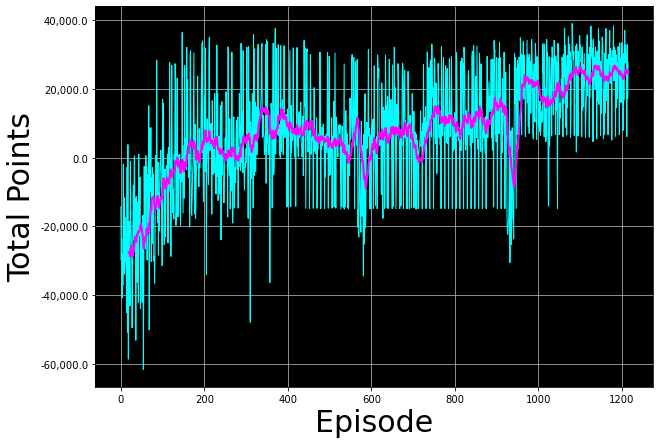

In [18]:
# Plot the point history
plot_history(total_point_history)

# Apply learned model and revisit results

In [19]:
import pprint
import sys
import logging
import Car
import Canvas
import RobotCarSimulator
import tensorflow as tf
from tensorflow.keras import Sequential
import numpy as np

model = tf.keras.models.load_model('curve_tracking_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________


In [28]:
def driveForward():
    global sim
    sim.driveForward(100,150)

def turnLeft():
    global sim
    sim.turnLeft(100,50)
    
def turnRight():
    global sim
    sim.turnRight(100,50)
    
actions = (driveForward, turnLeft, turnRight)
seed=


car = Car.CarModel()
# the seed controls the curve/line that we are following
canvas = Canvas.CanvasModel(seed=seed)
# we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=True)

while not sim.isTerminated() and sim.getDuration() < 20.0:
    state_qn = np.expand_dims(np.array(sim.getLineTrackingSensorValues()), axis=0)
    q_values = model(state_qn)
    action = np.argmax(q_values.numpy()[0])
    actions[action]()
    
sim.saveImage('model_seed_{}.gif'.format(seed))
with open('model_seed_{}.txt'.format(seed), 'w') as f:
    f.write("actions:\n")
    f.write(pprint.pformat(sim._actionLog))
    f.write("\n\npositions:\n")
    f.write(pprint.pformat(sim._carPositions))
    f.write("\n\norientations:\n")
    f.write(pprint.pformat(sim._carOrientations))